In [132]:
import numpy as np
import matplotlib.pyplot as plt
import random
import enum

# Задание 1

Решить линейную регрессию — найти прямую, которая описывает зависимость

N - количество осей (размерность) <br>
M - количество точек <br>
minValue - минимальное значение для иксов <br>
maxValue - максимальное значение для иксов

In [133]:
N = 1
M = 30
minValue = 0
maxValue = 5
EPS = 1e-5
K = 1e-2
beta_1 = 0.5
beta_2 = 0.5

class TypeOfOptimisation(enum.Enum):
    none = 0
    momentum = 1
    Nesterov = 2
    RMSProp = 3
    AdaGrad = 4
    Adam = 5


In [134]:
def y_regression(B, X):
    return np.sum(X * B)


B_reg = []
for ind in range(N + 1):
    bi = random.randint(-maxValue, maxValue)
    B_reg.append(bi)
B_reg = np.array(B_reg, dtype='float64')
print(B_reg)
XM = []
YM = []
YR = []
for ind in range(M):
    X = [1]
    for j in range(N):
        X.append(ind)
    X = np.array(X)
    rand_delta = random.randint(-maxValue, maxValue)
    Y_act = y_regression(B_reg, X) + 1 * rand_delta
    YM.append(Y_act)
    XM.append(np.array(X))
XM = np.array(XM, dtype='float64')
YM = np.array(YM)


def runSGD(typeOfOptimisation, withNormalization):
    B_start = np.array([0] * (N + 1), dtype='float64')
    YR = np.array([0] * M, dtype='float64')
    if withNormalization:
        X_norm = ZNormalization(XM)
        Y_norm = (YM - np.mean(YM)) / np.std(YM)
        BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
        BF_norm,
        errors_norm,
        YF_norm,
        iterations = gradient_descent(1,
                                      X_norm,
                                      Y_norm,
                                      YR,
                                      B_start,
                                      TypeOfOptimisation.none,
                                      with_normalization=False)

        print(errors_norm[0], errors_norm[len(errors_norm) - 1])
        print("actual coefficients:     ", BA_start)
        print("calculated coefficients: ", BF_norm)
        print("number of iterations:    ", iterations)
        drawGraph(X_norm, Y_norm, YF_norm)
        draw_errors_graphic(errors_norm, iterations)
    else:
        B_final,
        errors,
        YF,
        iterations = gradient_descent(1,
                                      XM,
                                      YM,
                                      YR,
                                      B_start,
                                      typeOfOptimisation,
                                      with_normalization=True)

        print(errors[0], errors[len(errors) - 1])
        print("actual coefficients:     ", B_reg)
        print("calculated coefficients: ", B_final)
        print("number of iterations:    ", iterations)
        drawGraph(XM, YM, YF)
        draw_errors_graphic(errors, iterations)

[ 3. -1.]


In [6]:
def squared_error(Y_act, Y_reg):
    return np.sum(abs(Y_act - Y_reg)) / M


def stopping_criteria(previous, current):
    return abs(previous - current) < EPS


def gradient(nums, XM, YR, YM):
    grad = []
    for i in range(N + 1):
        xi = 0
        for k in range(len(nums)):
            xi += XM[nums[k]][i] * (YR[nums[k]] - YM[nums[k]])
            if xi > 1e25:
                return np.array([0] * (N + 1), dtype='float64')
        grad.append(xi)
    return np.array(grad)


def gradient_descent(batch, XM, YM, YR, B_reg, type_of_optimisation, with_normalization):
    previous_error = 0
    grad = np.array([0] * (N + 1), dtype='float64')
    previous_gradient = np.array([0] * (N + 1), dtype='float64')
    m_adam = np.array([0] * (N + 1), dtype='float64')
    v_adam = np.array([0] * (N + 1), dtype='float64')
    errors = []
    iterations = 0
    while True:
        nums = set()
        while len(nums) != batch:
            x = random.randint(0, M - 1)
            if x not in nums:
                nums.add(x)
        nums = np.array(list(nums))

        # :NOTE: optimisations
        if type_of_optimisation == TypeOfOptimisation.none:
            grad = gradient(nums, XM, YR, YM)
        elif type_of_optimisation == TypeOfOptimisation.momentum:
            grad = gradient(nums, XM, YR, YM)
            grad += gamma * previous_gradient
        elif type_of_optimisation == TypeOfOptimisation.Nesterov:
            B_prev = B_reg - K * previous_gradient
            YR_new = [0] * M
            for i in range(M):
                YR_new[i] = y_regression(B_prev, XM[i])
            grad = gradient(nums, XM, np.array(YR_new), YM)
            grad += gamma * previous_gradient
        elif type_of_optimisation == TypeOfOptimisation.AdaGrad:
            grad = gradient(nums, XM, YR, YM)
            new_grad = np.sum(previous_gradient + np.square(grad))
            new_grad = np.delete(grad, np.sqrt(np.sum(new_grad + EPS)))
            grad = new_grad
        elif type_of_optimisation == TypeOfOptimisation.RMSProp:
            grad = gradient(nums, XM, YR, YM)
            new_grad = np.sum(gamma * previous_gradient + (1 - gamma) * np.square(grad))
            new_grad = np.delete(grad, np.sqrt(np.sum(new_grad + EPS)))
            grad = new_grad
        elif type_of_optimisation == TypeOfOptimisation.Adam:
            grad = gradient(nums, XM, YR, YM)
            m_adam = beta_1 * m_adam + (1 - beta_1) * grad
            v_adam = beta_2 * m_adam + (1 - beta_2) * np.square(grad)
            m = m_adam / (1 - beta_1)
            v = v_adam / (1 - beta_2)
            grad = m / np.sqrt(v + EPS)
        k = K
        if with_normalization:
            k *= 10
        B_reg -= k * grad

        for i in range(M):
            YR[i] = y_regression(B_reg, XM[i])
        if not with_normalization:
            if iterations >= 1000:
                break
        else:
            if stopping_criteria(previous_error, squared_error(YM, YR)):
                break
        previous_error = squared_error(YM, YR)
        previous_gradient = grad
        errors.append(previous_error)
        iterations += 1
    return B_reg, errors, YR, iterations


def drawGraph(XM, YM, YF):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    X = XM.T[1]
    plt.scatter(X, YM)
    plt.plot(X, YF, color='red')
    plt.title('linear regression')
    plt.show()


def draw_errors_graphic(E, iterations):
    i = np.linspace(0, iterations, iterations)
    plt.plot(i, E)
    plt.title('errors dependency')
    plt.show()


runSGD(TypeOfOptimisation.none, withNormalization=False)

NameError: name 'runSGD' is not defined

# Задание 2

0.8339999579707554 0.3200021129918504
actual coefficients:      [ 1. -1.]
calculated coefficients:  [-0.01383851 -0.94817721]
number of iterations:     1000


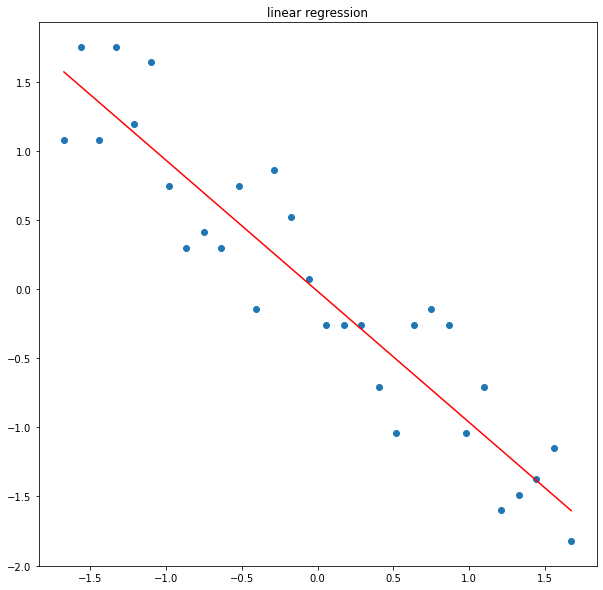

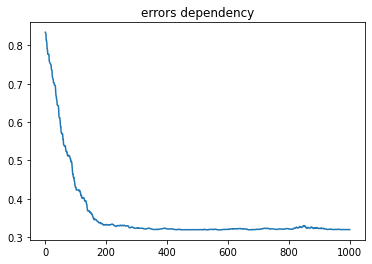

In [136]:
def ZNormalization(XM):
    X = XM.T
    for i in range(1, N + 1):
        X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
    return X.T


# print(XM)
runSGD(TypeOfOptimisation.none, withNormalization=True)

# Задание 3

### Метод моментов

Смысл заключается в том, что мы на каждом шаге прибавляем к значению градиента
предыдущий градиент умноженный на константу. Это позволяет градиентному спуску не застревать
в локальных минимумах.

10.463210975157581 3.3914791830422026
actual coefficients:      [ 3. -1.]
calculated coefficients:  [-9.81824805 -9.53660672]
number of iterations:     8952
0.826640778687475 0.32542494187767823
actual coefficients:      [ 1. -1.]
calculated coefficients:  [-0.00780695 -0.87234916]
number of iterations:     1000


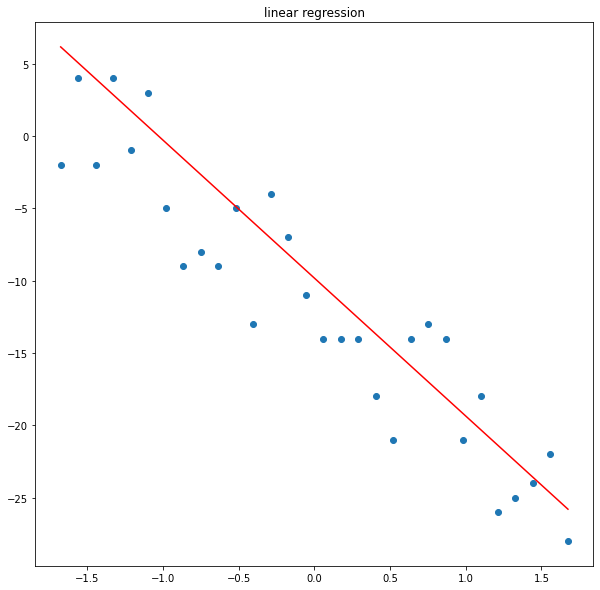

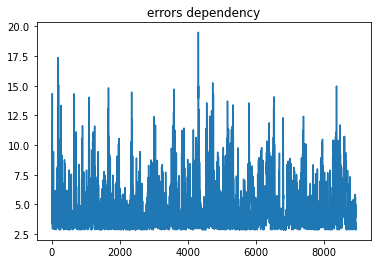

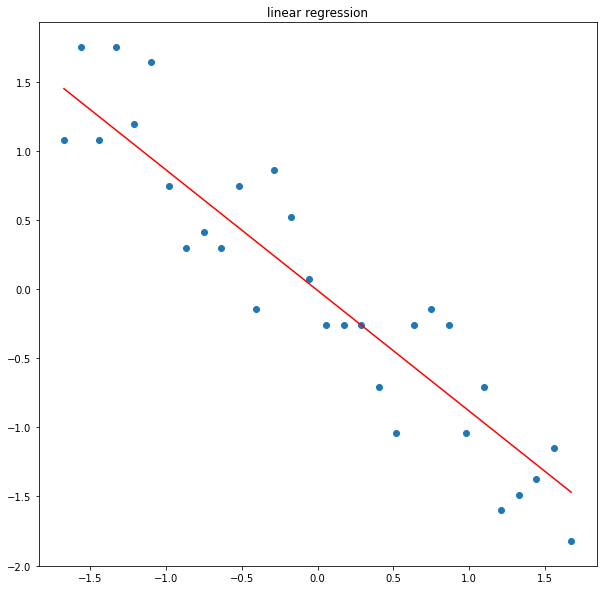

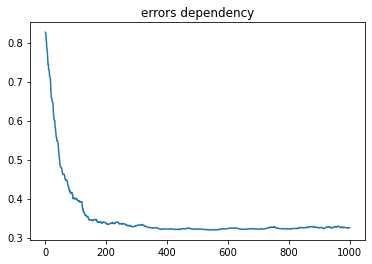

In [137]:
gamma = 0.9

runSGD(TypeOfOptimisation.momentum, withNormalization=False)
runSGD(TypeOfOptimisation.momentum, withNormalization=True)

### Метод Нестерова

Здесь используется тот же смысл, как и в методе моментов, только градиент мы считаем не от текущей точки,
а от следующей (как бы заглядывая вперед). Дает более быструю сходимость, чем метод моментов.

12.170189098998888 3.5274356875067236
actual coefficients:      [ 3. -1.]
calculated coefficients:  [-10.72929826 -10.9838692 ]
number of iterations:     1127
0.8336175104217691 0.321241376233039
actual coefficients:      [ 1. -1.]
calculated coefficients:  [ 0.01272013 -0.94584612]
number of iterations:     1000


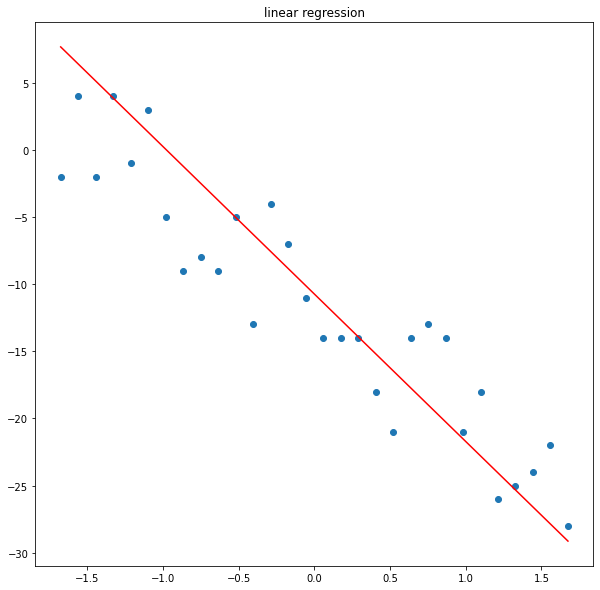

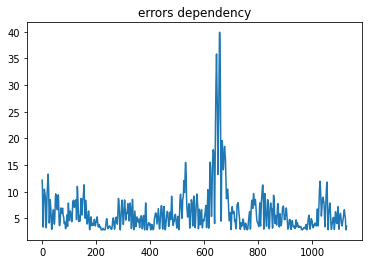

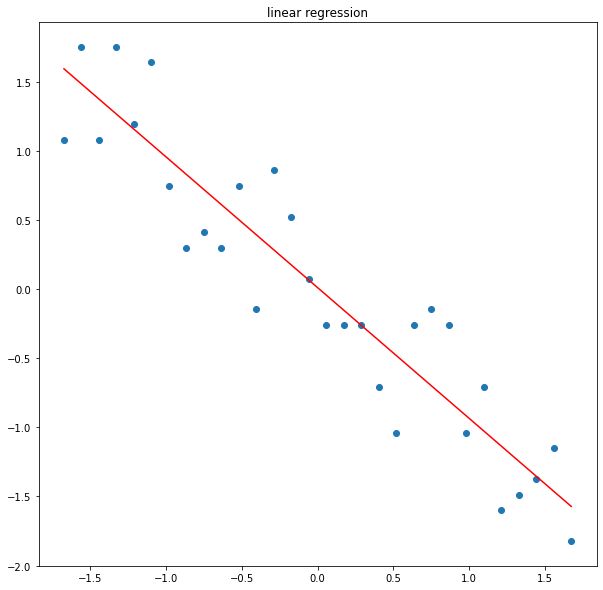

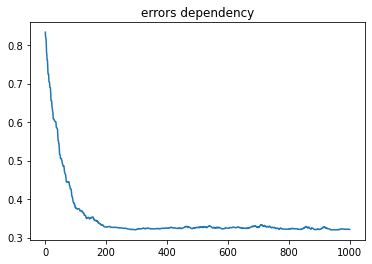

In [138]:
runSGD(TypeOfOptimisation.Nesterov, withNormalization=False)
runSGD(TypeOfOptimisation.Nesterov, withNormalization=True)